Loading data...

--- STATISTICAL SUMMARY (T-Test against 0) ---
Transitive - Core:
  s-PE: Mean=0.7948, SE=0.0055, p=0.00e+00
  w-PE: Mean=0.1566, SE=0.0029, p=0.00e+00
Transitive - Anomalous:
  s-PE: Mean=0.6081, SE=0.0050, p=0.00e+00
  w-PE: Mean=0.1365, SE=0.0028, p=0.00e+00
Transitive - Jabberwocky:
  s-PE: Mean=1.8812, SE=0.0077, p=0.00e+00
  w-PE: Mean=0.0040, SE=0.0034, p=2.35e-01


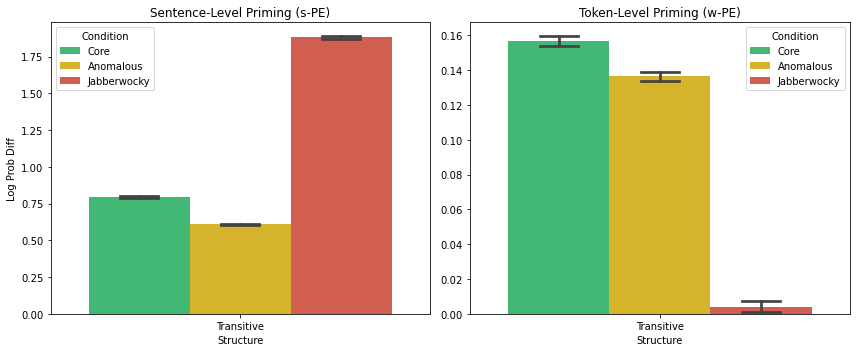

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import numpy as np

# --- CONFIGURATION ---
INPUT_DIR = "results/results_behavioral/transitive"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 1. LOAD AND PROCESS DATA ---
all_data = []

print("Loading data...")
for filename in os.listdir(INPUT_DIR):
    if not filename.endswith(".csv"): continue
    
    filepath = os.path.join(INPUT_DIR, filename)
    df = pd.read_csv(filepath)
    
    # Parse filename to get metadata (e.g., "scores_jabberwocky_transitive.csv")
    # Assuming format: scores_[CONDITION]_[STRUCTURE].csv
    name_parts = filename.replace("scores_", "").replace(".csv", "").split("_")
    
    # Handle naming variations carefully
    if "jabberwocky" in filename:
        condition = "Jabberwocky"
    elif "ANOMALOUS" in filename:
        condition = "Anomalous"
    elif "CORE" in filename:
        condition = "Core"
    else:
        condition = "Unknown"
        
    if "transitive" in filename:
        structure = "Transitive"
        # Calculate Net PE (Average of Active and Passive)
        df['s_PE_Net'] = (df['s_PE_Active'] + df['s_PE_Passive']) / 2
        df['w_PE_Net'] = (df['w_PE_Active'] + df['w_PE_Passive']) / 2
    elif "dative" in filename:
        structure = "dative"
        # Calculate Net PE (Average of DO and PO)
        df['s_PE_Net'] = (df['s_PE_DO'] + df['s_PE_PO']) / 2
        df['w_PE_Net'] = (df['w_PE_DO'] + df['w_PE_PO']) / 2
    else:
        continue

    df['Condition'] = condition
    df['Structure'] = structure
    all_data.append(df)

if not all_data:
    print("No data found! Check your folder.")
    exit()

full_df = pd.concat(all_data, ignore_index=True)

# --- 2. STATISTICAL SUMMARY ---
print("\n--- STATISTICAL SUMMARY (T-Test against 0) ---")
summary_stats = []

for struct in full_df['Structure'].unique():
    for cond in ["Core", "Anomalous", "Jabberwocky"]:
        subset = full_df[(full_df['Structure'] == struct) & (full_df['Condition'] == cond)]
        
        if len(subset) == 0: continue
        
        # T-Test for s-PE
        t_stat_s, p_val_s = stats.ttest_1samp(subset['s_PE_Net'], 0)
        mean_s = subset['s_PE_Net'].mean()
        se_s = subset['s_PE_Net'].sem() # Standard Error
        
        # T-Test for w-PE (drop NaNs if any)
        w_clean = subset['w_PE_Net'].dropna()
        t_stat_w, p_val_w = stats.ttest_1samp(w_clean, 0)
        mean_w = w_clean.mean()
        se_w = w_clean.sem()
        
        print(f"{struct} - {cond}:")
        print(f"  s-PE: Mean={mean_s:.4f}, SE={se_s:.4f}, p={p_val_s:.2e}")
        print(f"  w-PE: Mean={mean_w:.4f}, SE={se_w:.4f}, p={p_val_w:.2e}")
        
        summary_stats.append({
            "Structure": struct, "Condition": cond,
            "s_PE_Mean": mean_s, "s_PE_SE": se_s,
            "w_PE_Mean": mean_w, "w_PE_SE": se_w
        })

# --- 3. VISUALIZATION (Figure 1) ---
# We want a plot with 2 subplots: Sentence-Level and Token-Level
# --- REPLACEMENT PLOTTING CODE ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False) # Changed sharey to False to see w-PE better

# Order and Palette
order = ["Core", "Anomalous", "Jabberwocky"]
palette = {"Core": "#2ecc71", "Anomalous": "#f1c40f", "Jabberwocky": "#e74c3c"}

# Subplot 1: Sentence-Level (s-PE)
# Removed 'errorbar', added 'ci=68' (Standard Error)
sns.barplot(data=full_df, x="Structure", y="s_PE_Net", hue="Condition", 
            hue_order=[c for c in order if c in full_df['Condition'].unique()],
            palette=palette, ci=68, ax=axes[0], capsize=0.1)
axes[0].set_title("Sentence-Level Priming (s-PE)")
axes[0].set_ylabel("Log Prob Diff")
axes[0].axhline(0, color='black', linewidth=1, linestyle='--')

# Subplot 2: Token-Level (w-PE)
sns.barplot(data=full_df, x="Structure", y="w_PE_Net", hue="Condition", 
            hue_order=[c for c in order if c in full_df['Condition'].unique()],
            palette=palette, ci=68, ax=axes[1], capsize=0.1)
axes[1].set_title("Token-Level Priming (w-PE)")
axes[1].set_ylabel("") 
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [2]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")

# Test a few Jabberwocky sentences from your corpus
sentences = [
    " The dax gimbled the wug .",       # Active
    " The wug was gimbled by the dax ." # Passive
]

print(f"{'Token':<15} | {'ID':<6} | {'Index'}")
print("-" * 35)

for text in sentences:
    print(f"\nAnalyzing: '{text}'")
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.encode(text)
    
    for i, (tok, idx) in enumerate(zip(tokens, ids)):
        print(f"{tok:<15} | {idx:<6} | {i}")

Token           | ID     | Index
-----------------------------------

Analyzing: ' The dax gimbled the wug .'
ĠThe            | 383    | 0
Ġd              | 288    | 1
ax              | 897    | 2
Ġg              | 308    | 3
im              | 320    | 4
bled            | 9342   | 5
Ġthe            | 262    | 6
Ġw              | 266    | 7
ug              | 1018   | 8
Ġ.              | 764    | 9

Analyzing: ' The wug was gimbled by the dax .'
ĠThe            | 383    | 0
Ġw              | 266    | 1
ug              | 1018   | 2
Ġwas            | 373    | 3
Ġg              | 308    | 4
im              | 320    | 5
bled            | 9342   | 6
Ġby             | 416    | 7
Ġthe            | 262    | 8
Ġd              | 288    | 9
ax              | 897    | 10
Ġ.              | 764    | 11
